In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
train_file_path = '/content/drive/My Drive/drug_review/drugsComTrain_raw.csv'
test_file_path = '/content/drive/My Drive/drug_review/drugsComTest_raw.csv'
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
data = pd.concat([train_data, test_data])

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = text.lower()
    text = text.strip()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
# Download stopwords
nltk.download('stopwords')

# Preprocess the reviews
data['clean_review'] = data['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['clean_review'])
X = tokenizer.texts_to_sequences(data['clean_review'])
maxlen = 100  # Define maxlen for padding
X = pad_sequences(X, padding='post', maxlen=maxlen)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [ ]:
# Define the Self-Attention layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        u = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(u, axis=1)
        output = tf.reduce_sum(a * x, axis=1)
        return output

In [ ]:
# Function to build and compile GRU model with self-attention
def build_gru_model(output_dim, output_units, loss, activation='softmax'):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(SelfAttention())
    model.add(Dense(output_units, activation=activation))
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    return model

In [ ]:
# Encode the target variable
le_condition = LabelEncoder()
y_condition = le_condition.fit_transform(data['condition'])

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_condition, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Build and train the model for condition prediction
model_condition = build_gru_model(output_dim=100, output_units=y_train.shape[1], loss='categorical_crossentropy')
history_condition = model_condition.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
1210/1210 [==============================] - 295s 239ms/step - loss: 3.5461 - accuracy: 0.3092 - val_loss: 2.6075 - val_accuracy: 0.4591
Epoch 2/5
1210/1210 [==============================] - 250s 206ms/step - loss: 2.1989 - accuracy: 0.5302 - val_loss: 1.8763 - val_accuracy: 0.5865
Epoch 3/5
1210/1210 [==============================] - 251s 207ms/step - loss: 1.6557 - accuracy: 0.6289 - val_loss: 1.5906 - val_accuracy: 0.6452
Epoch 4/5
1210/1210 [==============================] - 254s 210ms/step - loss: 1.3501 - accuracy: 0.6876 - val_loss: 1.4530 - val_accuracy: 0.6697
Epoch 5/5
1210/1210 [==============================] - 253s 209ms/step - loss: 1.1436 - accuracy: 0.7291 - val_loss: 1.3642 - val_accuracy: 0.6960


In [ ]:
# Evaluate the model for condition prediction
y_pred_condition = model_condition.predict(X_test)
y_pred_condition_classes = np.argmax(y_pred_condition, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print('Classification Report for Condition Prediction:\n', classification_report(y_test_classes, y_pred_condition_classes))
print('Confusion Matrix for Condition Prediction:\n', confusion_matrix(y_test_classes, y_pred_condition_classes))

1345/1345 [==============================] - 35s 26ms/step
Classification Report for Condition Prediction:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           3       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         5
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         4
          20       0.00      0.00      0.00        20
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         4
          23       0.00      0.00      0.00         1
          24       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Task 02: Estimating drug ratings from reviews (Regression)
y_rating = data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y_rating, test_size=0.2, random_state=42)
model_rating = build_gru_model(output_dim=100, output_units=1, loss='mean_squared_error', activation='linear')
history_rating = model_rating.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)
y_pred_rating = model_rating.predict(X_test)
print('Mean Squared Error for Rating Prediction:', mean_squared_error(y_test, y_pred_rating))

Epoch 1/5
1210/1210 [==============================] - 283s 230ms/step - loss: 6.9002 - accuracy: 0.1320 - val_loss: 5.0784 - val_accuracy: 0.1337
Epoch 2/5
1210/1210 [==============================] - 254s 210ms/step - loss: 4.3840 - accuracy: 0.1338 - val_loss: 4.8242 - val_accuracy: 0.1340
Epoch 3/5
1210/1210 [==============================] - 253s 209ms/step - loss: 3.5757 - accuracy: 0.1335 - val_loss: 4.3341 - val_accuracy: 0.1333
Epoch 4/5
1210/1210 [==============================] - 252s 208ms/step - loss: 2.9569 - accuracy: 0.1330 - val_loss: 4.1967 - val_accuracy: 0.1334
Epoch 5/5
1345/1345 [==============================] - 34s 25ms/step
Mean Squared Error for Rating Prediction: 3.9504792392623775


In [ ]:
# Task 03: Identifying elements that make reviews helpful (Linear Regression)
data['usefulCount'] = data['usefulCount'].fillna(0).astype(int)
y_helpful = data['usefulCount']
X_train, X_test, y_train, y_test = train_test_split(X, y_helpful, test_size=0.2, random_state=42)
model_helpful = build_gru_model(output_dim=100, output_units=1, loss='mean_squared_error', activation='linear')
history_helpful = model_helpful.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)
y_pred_helpful = model_helpful.predict(X_test)
print('Mean Squared Error for Helpful Prediction:', mean_squared_error(y_test, y_pred_helpful))

Epoch 1/5
1210/1210 [==============================] - 276s 226ms/step - loss: 1218.7417 - accuracy: 0.0386 - val_loss: 1212.6128 - val_accuracy: 0.0377
Epoch 2/5
1210/1210 [==============================] - 248s 205ms/step - loss: 1074.1746 - accuracy: 0.0386 - val_loss: 1066.8624 - val_accuracy: 0.0375
Epoch 3/5
1210/1210 [==============================] - 248s 205ms/step - loss: 896.3658 - accuracy: 0.0385 - val_loss: 969.6345 - val_accuracy: 0.0372
Epoch 4/5
1210/1210 [==============================] - 249s 206ms/step - loss: 775.5852 - accuracy: 0.0385 - val_loss: 925.3954 - val_accuracy: 0.0370
Epoch 5/5
1345/1345 [==============================] - 34s 25ms/step
Mean Squared Error for Helpful Prediction: 841.6280130119286


In [ ]:
# Function to map ratings to sentiments
def get_sentiment(score):
    if score >= 7:
        return 2  # Positive
    elif score <= 4:
        return 0  # Negative
    else:
        return 1  # Neutral

# Add sentiment column to the data
data['sentiment'] = data['rating'].apply(get_sentiment)
y_sentiment = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build and train the model for sentiment analysis
model_sentiment = build_gru_model(output_dim=100, output_units=y_train.shape[1], loss='categorical_crossentropy')
history_sentiment = model_sentiment.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

# Evaluate the model for sentiment analysis
y_pred_sentiment = model_sentiment.predict(X_test)
y_pred_sentiment_classes = np.argmax(y_pred_sentiment, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print('Classification Report for Sentiment Analysis:\n', classification_report(y_test_classes, y_pred_sentiment_classes))

Epoch 1/5
1210/1210 [==============================] - 277s 226ms/step - loss: 0.5873 - accuracy: 0.7763 - val_loss: 0.5341 - val_accuracy: 0.7968
Epoch 2/5
1210/1210 [==============================] - 256s 212ms/step - loss: 0.4624 - accuracy: 0.8251 - val_loss: 0.4961 - val_accuracy: 0.8123
Epoch 3/5
1210/1210 [==============================] - 255s 211ms/step - loss: 0.3825 - accuracy: 0.8566 - val_loss: 0.4824 - val_accuracy: 0.8185
Epoch 4/5
1210/1210 [==============================] - 253s 209ms/step - loss: 0.3082 - accuracy: 0.8861 - val_loss: 0.4791 - val_accuracy: 0.8339
Epoch 5/5
1345/1345 [==============================] - 35s 26ms/step
Classification Report for Sentiment Analysis:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78     10722
           1       0.59      0.39      0.47      3945
           2       0.88      0.94      0.91     28346

    accuracy                           0.84     43013
   macro avg       0.76 

In [ ]:
# Task 05: Classifying reviews as positive, negative, or neutral (Classification)
y_sentiment = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
model_sentiment = build_gru_model(output_dim=100, output_units=y_train.shape[1], loss='categorical_crossentropy')
history_sentiment = model_sentiment.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)
y_pred_sentiment = model_sentiment.predict(X_test)
y_pred_sentiment_classes = np.argmax(y_pred_sentiment, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print('Classification Report for Sentiment Classification:\n', classification_report(y_test_classes, y_pred_sentiment_classes))
print('Confusion Matrix for Sentiment Classification:\n', confusion_matrix(y_test_classes, y_pred_sentiment_classes))
print('Accuracy for Sentiment Classification:', accuracy_score(y_test_classes, y_pred_sentiment_classes))

Epoch 1/5
1210/1210 [==============================] - 282s 230ms/step - loss: 0.5892 - accuracy: 0.7766 - val_loss: 0.5318 - val_accuracy: 0.7999
Epoch 2/5
1210/1210 [==============================] - 252s 208ms/step - loss: 0.4654 - accuracy: 0.8239 - val_loss: 0.4959 - val_accuracy: 0.8096
Epoch 3/5
1210/1210 [==============================] - 249s 205ms/step - loss: 0.3870 - accuracy: 0.8551 - val_loss: 0.4822 - val_accuracy: 0.8178
Epoch 4/5
1210/1210 [==============================] - 247s 204ms/step - loss: 0.3161 - accuracy: 0.8830 - val_loss: 0.4922 - val_accuracy: 0.8323
Epoch 5/5
1345/1345 [==============================] - 34s 25ms/step
Classification Report for Sentiment Classification:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78     10722
           1       0.57      0.40      0.47      3945
           2       0.87      0.94      0.91     28346

    accuracy                           0.84     43013
   macro avg      

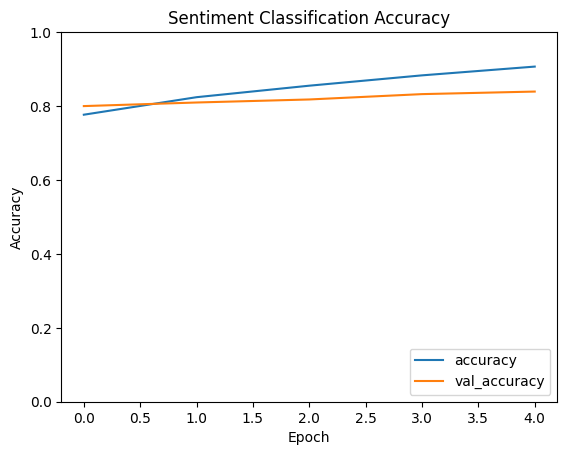

In [ ]:
# Plot training history
def plot_training_history(history, title):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()

plot_training_history(history_sentiment, 'Sentiment Classification Accuracy')

In [ ]:
# Task 06: Exploring drugs and its associated conditions (Filtering)
def explore_drug(drug_name):
    filtered_data = data[data['drugName'].str.contains(drug_name, case=False, na=False)]
    if filtered_data.empty:
        print(f"No data found for drug: {drug_name}")
        return pd.DataFrame()
    return filtered_data[['drugName', 'condition', 'review', 'rating']]

In [ ]:
# Example usage
explored_drug = explore_drug('aspirin')
if not explored_drug.empty:
    print(explored_drug.head())

                                drugName  condition  \
310      Aspirin / butalbital / caffeine   Migraine   
335   Acetaminophen / aspirin / caffeine  Pain/Feve   
1275  Acetaminophen / aspirin / caffeine   Migraine   
1362  Acetaminophen / aspirin / caffeine   Migraine   
1532                  Aspirin / caffeine       Pain   

                                                 review  rating  
310   "This drug is phenomenal for migraines as long...      10  
335   "I don&#039;t get headaches very often, but wh...      10  
1275  "I have had migraines for almost 40 years. I h...      10  
1362  "My Migraine headache starts with what they ca...       8  
1532  "This med really works plus the little bit of ...      10  


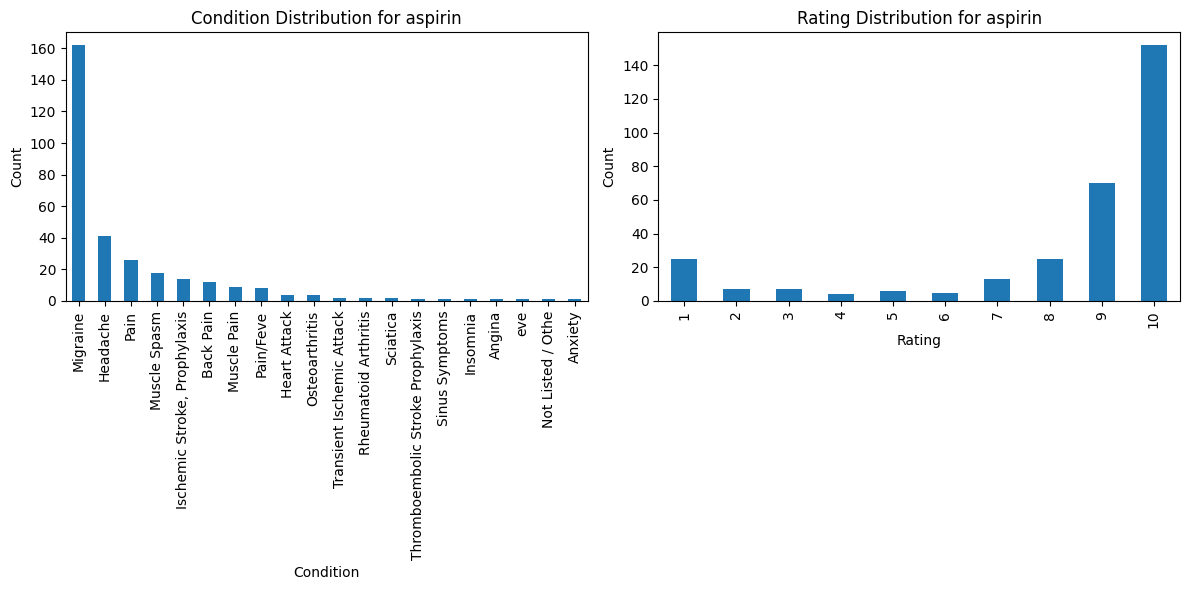

In [ ]:
# Visualizing the distribution of conditions and ratings for a specific drug
def plot_drug_distribution(drug_name):
    filtered_data = explore_drug(drug_name)
    if filtered_data.empty:
        return

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    filtered_data['condition'].value_counts().plot(kind='bar')
    plt.title(f'Condition Distribution for {drug_name}')
    plt.xlabel('Condition')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    filtered_data['rating'].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Rating Distribution for {drug_name}')
    plt.xlabel('Rating')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Example usage
plot_drug_distribution('aspirin')

In [ ]:
# from gensim.corpora import Dictionary
# from gensim.models import LdaModel

# # Preprocess the reviews for topic modeling
# data['clean_review'] = data['review'].apply(preprocess_text)
# reviews_clean = [review.split() for review in data['clean_review']]

# # Create a Gensim dictionary and corpus
# dictionary = Dictionary(reviews_clean)
# corpus = [dictionary.doc2bow(review) for review in reviews_clean]

# # Train an LDA model
# lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Assuming data is a pandas DataFrame and preprocess_text is a function
data['clean_review'] = data['review'].apply(preprocess_text)
reviews_clean = [review.split() for review in data['clean_review']]
# Create a Gensim dictionary and corpus
dictionary = Dictionary(reviews_clean)
corpus = [dictionary.doc2bow(review) for review in reviews_clean]

# Train an LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
# Convert the text data into a TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(data['clean_review'])

# Train an NMF model
nmf_model = NMF(n_components=5, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)
# Get topic distributions for each document from the LDA model
lda_topics = []
for bow in corpus:
    doc_topics = [0] * 5
    for topic_num, prob in lda_model.get_document_topics(bow):
        doc_topics[topic_num] = prob
    lda_topics.append(doc_topics)

lda_topics = np.array(lda_topics)

# Combine the topic distributions
ensembled_topics = (lda_topics + nmf_topics) / 2

# Convert to a DataFrame for easier interpretation
ensembled_topics_df = pd.DataFrame(ensembled_topics, columns=[f'Topic_{i}' for i in range(1, 6)])


In [ ]:
# def identify_reason(review_text):
#     # Implement your logic to identify the reason for a negative review
#     # This is a placeholder implementation
#     negative_keywords = ['side effect', 'not effective', 'bad experience', 'expensive', 'poor quality']
#     for keyword in negative_keywords:
#         if keyword in review_text.lower():
#             return keyword
#     return "General dissatisfaction"
def identify_reason(review_text):
    # Example logic to identify reason, replace with actual implementation
    reasons = {
        "side effects": ["side effect", "adverse effect", "reaction"],
        "ineffective": ["not work", "no effect", "ineffective"],
        "cost": ["expensive", "costly", "price"]
    }
    for reason, keywords in reasons.items():
        for keyword in keywords:
            if keyword in review_text.lower():
                return reason
    return "other"

In [ ]:
def map_condition_to_cure_status(condition):
    # Example mapping logic, this should be defined based on your criteria
    cured_conditions = ['Hypertension', 'Diabetes', 'Pain']  # Replace with actual cured conditions
    if condition in cured_conditions:
        return "cured"
    else:
        return "not cured"

# Update labels in the dataset
data['cure_status'] = data['condition'].apply(map_condition_to_cure_status)

# Encode the target variable for cure status
le_cure_status = LabelEncoder()
y_cure_status = le_cure_status.fit_transform(data['cure_status'])

In [ ]:
# Build and train the model for cure status prediction
model_cure_status = build_gru_model(output_dim=100, output_units=y_train.shape[1], loss='categorical_crossentropy')
history_cure_status = model_sentiment.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
1210/1210 [==============================] - 255s 211ms/step - loss: 0.2100 - accuracy: 0.9236 - val_loss: 0.5328 - val_accuracy: 0.8468
Epoch 2/5
1210/1210 [==============================] - 253s 209ms/step - loss: 0.1787 - accuracy: 0.9344 - val_loss: 0.5528 - val_accuracy: 0.8517
Epoch 3/5
1210/1210 [==============================] - 252s 208ms/step - loss: 0.1535 - accuracy: 0.9440 - val_loss: 0.5889 - val_accuracy: 0.8538
Epoch 4/5
1210/1210 [==============================] - 254s 210ms/step - loss: 0.1323 - accuracy: 0.9515 - val_loss: 0.6727 - val_accuracy: 0.8563
Epoch 5/5
1210/1210 [==============================] - 255s 211ms/step - loss: 0.1176 - accuracy: 0.9571 - val_loss: 0.6674 - val_accuracy: 0.8606


In [ ]:
# Define a function to predict cure status from a review
def predict_cure_status(review_text, cure_status_model, tokenizer, maxlen, label_encoder):
    review_seq = tokenizer.texts_to_sequences([review_text])
    review_pad = pad_sequences(review_seq, maxlen=maxlen, padding='post')
    predicted_cure_status = cure_status_model.predict(review_pad)
    cure_status_class = np.argmax(predicted_cure_status, axis=1)[0]
    return label_encoder.inverse_transform([cure_status_class])[0]

In [ ]:
pip install pandas reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.7 MB/s eta 0:00:00


In [ ]:
medicine_dataset_path = '/content/drive/My Drive/druf_info/medicine_dataset.csv'
medicine_data = pd.read_csv(medicine_dataset_path)

<ipython-input-40-040dbce8e28e>:2: DtypeWarning: Columns (42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  medicine_data = pd.read_csv(medicine_dataset_path)


In [ ]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter

In [ ]:
def generate_pdf_report(drug_name):
    drug_info = medicine_data[medicine_data['name'].str.contains(drug_name, case=False, na=False)]
    if drug_info.empty:
        print("No information found for the drug:", drug_name)
        return

    file_name = f"{drug_name}_report.pdf"
    c = canvas.Canvas(file_name, pagesize=letter)
    c.setFont("Helvetica", 12)

    # Header
    c.drawString(100, 750, f"Report for Drug: {drug_name}")

    # Basic Information
    y = 730
    for column in drug_info.columns:
        value = drug_info[column].values[0]
        if pd.notna(value):
            c.drawString(50, y, f"{column}: {value}")
            y -= 20

    # Save PDF
    c.save()
    print(f"PDF report generated: {file_name}")

In [ ]:
# Define a function to predict cure status from a review
def predict_cure_status(review_text, cure_status_model, tokenizer, maxlen, label_encoder):
    review_seq = tokenizer.texts_to_sequences([review_text])
    review_pad = pad_sequences(review_seq, maxlen=maxlen, padding='post')
    predicted_cure_status = cure_status_model.predict(review_pad)
    cure_status_class = np.argmax(predicted_cure_status, axis=1)[0]
    return label_encoder.inverse_transform([cure_status_class])[0]

# Define the necessary functions for main
def predict_rating(review_text, rating_model, tokenizer, maxlen):
    review_seq = tokenizer.texts_to_sequences([review_text])
    review_pad = pad_sequences(review_seq, maxlen=maxlen, padding='post')
    predicted_rating = rating_model.predict(review_pad)
    return predicted_rating[0][0]

def predict_sentiment(review_text, sentiment_model, tokenizer, maxlen):
    review_seq = tokenizer.texts_to_sequences([review_text])
    review_pad = pad_sequences(review_seq, maxlen=maxlen, padding='post')
    predicted_sentiment = sentiment_model.predict(review_pad)
    sentiment_class = np.argmax(predicted_sentiment, axis=1)[0]
    return ['Negative', 'Neutral', 'Positive'][sentiment_class]

def predict_drug_info(drug_name, train_df, test_df, rating_model, sentiment_model, tokenizer, maxlen, label_encoder, dictionary, lda_model):
    # Filtering and merging data
    drug_data = pd.concat([train_df, test_df])
    filtered_data = drug_data[drug_data['drugName'].str.contains(drug_name, case=False, na=False)]

    # Predicting conditions
    conditions = filtered_data['condition'].unique().tolist()

    # Predicting ratings and sentiments for each review
    filtered_data['predicted_rating'] = filtered_data['review'].apply(lambda x: predict_rating(x, rating_model, tokenizer, maxlen))
    filtered_data['predicted_sentiment'] = filtered_data['review'].apply(lambda x: predict_sentiment(x, sentiment_model, tokenizer, maxlen))

    # Extracting some reviews
    reviews = filtered_data[['review', 'rating', 'predicted_rating', 'predicted_sentiment']].head(5)

    # Topic modeling (LDA) to identify topics in reviews
    reviews_clean = [preprocess_text(review) for review in filtered_data['review']]
    reviews_bow = [dictionary.doc2bow(review.split()) for review in reviews_clean]
    topics = lda_model.show_topics(num_words=4)

    return conditions, reviews, topics

# Main function for user interaction
def main():
    while True:
        print("\nWelcome to Drug Review Analysis System!")
        print("1. Analyze Rating of a Review")
        print("2. Get Drug Information")
        print("3. Reason behind negative review")
        print("4. Predict Cure Status from Review")
        print("5. Generate report about report")
        print("6. Exit")
        choice = input("Enter your choice (1/2/3/4/5/6): ")

        if choice == '1':
            review_text = input("Enter your review text: ")
            rating = predict_rating(review_text, model_rating, tokenizer, maxlen)
            sentiment = predict_sentiment(review_text, model_sentiment, tokenizer, maxlen)
            print(f"Predicted Rating: {rating:.2f}")
            print(f"Predicted Sentiment: {sentiment}")

        elif choice == '2':
            drug_name = input("Enter the name of the drug: ")
            conditions, reviews, topics = predict_drug_info(drug_name, train_data, test_data, model_rating, model_sentiment, tokenizer, maxlen, le_condition, dictionary, lda_model)

            print(f"\nConditions for using {drug_name}:")
            for condition in conditions:
                print(f"- {condition}")

            print(f"\nSome Reviews for {drug_name}:")
            for index, row in reviews.iterrows():
                print(f"Review {index + 1}:")
                print(f"Rating: {row['rating']}")
                print(f"Predicted Rating: {row['predicted_rating']:.2f}")
                print(f"Predicted Sentiment: {row['predicted_sentiment']}")
                print(f"Review: {row['review']}")
                print()

            print("Topics in Reviews:")
            for topic in topics:
                print(topic)

        elif choice == '3':
            review_text = input("Enter your review text: ")
            sentiment = predict_sentiment(review_text, model_sentiment, tokenizer, maxlen)
            if sentiment == 'Negative':
                reason = identify_reason(review_text)
                print(f"Reason for Negative Review: {reason}")
            else:
                print("The review is not negative.")

        elif choice == '4':
            review_text = input("Enter your review text: ")
            cure_status = predict_cure_status(review_text, model_cure_status, tokenizer, maxlen, le_cure_status)
            print(f"Predicted Cure Status: {cure_status}")

        elif choice == '5':
            drug_name = input("Enter the drug name: ")
            generate_pdf_report(drug_name)

        elif choice == '6':
            print("Exiting the program...")
            break

        else:
            print("Invalid choice. Please enter 1, 2, 3, 4, or 5.")

if __name__ == "__main__":
    main()


Welcome to Drug Review Analysis System!
1. Analyze Rating of a Review
2. Get Drug Information
3. Reason behind negative review
4. Predict Cure Status from Review
5. Generate report about report
6. Exit
Enter your choice (1/2/3/4/5/6): 5
Enter the drug name: augmentin 625 duo tablet
PDF report generated: augmentin 625 duo tablet_report.pdf

Welcome to Drug Review Analysis System!
1. Analyze Rating of a Review
2. Get Drug Information
3. Reason behind negative review
4. Predict Cure Status from Review
5. Generate report about report
6. Exit
Enter your choice (1/2/3/4/5/6): 6
Exiting the program...


In [ ]:
# Saving the condition prediction model
model_condition.save('/content/drive/My Drive/drug_review/MODELS/model_condition.h5')
print("Condition prediction model saved as model_condition.h5")

# Saving the rating prediction model
model_rating.save('/content/drive/My Drive/drug_review/MODELS/model_rating.h5')
print("Rating prediction model saved as model_rating.h5")

# Saving the helpful review prediction model
model_helpful.save('/content/drive/My Drive/drug_review/MODELS/model_helpful.h5')
print("Helpful review prediction model saved as model_helpful.h5")

# Saving the sentiment analysis model
model_sentiment.save('/content/drive/My Drive/drug_review/MODELS/model_sentiment.h5')
print("Sentiment analysis model saved as model_sentiment.h5")

# Saving the cure status prediction model
model_cure_status.save('/content/drive/My Drive/drug_review/MODELS/model_cure_status.h5')
print("Cure status prediction model saved as model_cure_status.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Condition prediction model saved as model_condition.h5
Rating prediction model saved as model_rating.h5
Helpful review prediction model saved as model_helpful.h5
Sentiment analysis model saved as model_sentiment.h5
Cure status prediction model saved as model_cure_status.h5
